<a href="https://colab.research.google.com/github/MathewBiddle/obis-mapping/blob/main/OBIS_parquet_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using pyobis to query for known datasets

Created: 2023-07-27


Author: [Mathew Biddle](mailto:mathew.biddle@noaa.gov)

This notebook uses pandas to read the full OBIS export in parquet format.

![image.png](https://obis.org/images/logo.png)

The parquet file can be accessed at https://obis.org/data/access/. The most recent parquet file is available at https://obis-datasets.ams3.digitaloceanspaces.com/exports/obis_20230208.parquet

This notebook is an attempt to rewrite Ben Best's notebook https://bbest.github.io/obis-lat-time-fig/ in the Python programming language and provide a mechanism to rerun the notebook when new data are available.

## Query the OBIS aggregated points

Now that we know the general area for where our observations are made, let's dig a little deeper into each dataset.

We can use [`pyobis.occurrences.getpoints()`](https://iobis.github.io/pyobis/occurrences.html#pyobis.occurrences.getpoints) to return all of the points for each dataset, aggregated to [Geohash precision 8](https://en.wikipedia.org/wiki/Geohash).

If we'd like a little more metadata about each of the aggregated points, we can query by dataset to collect the aggregated points and some useful metadata.

In [ ]:
import pandas as pd
import geopandas

columns = ["dataset_id","decimalLatitude","decimalLongitude"]

combined = pd.read_parquet('../../../../../obis_20220710.parquet', engine='fastparquet', columns=columns)

combined

,dataset_id,decimalLatitude,decimalLongitude
0,364e5a12-8028-4329-be50-fc548c2d6ce4,-34.025002,15.941700
1,46c52e34-73b7-45e6-a2ac-742e4c2058c5,60.073334,26.341667
2,46c52e34-73b7-45e6-a2ac-742e4c2058c5,-60.066666,-26.350000
3,e72b87e0-6a52-4e94-a0b0-f0401d41841f,-27.950001,154.050003
4,364e5a12-8028-4329-be50-fc548c2d6ce4,-28.666651,13.400000
...,...,...,...
105316741,9a37fc55-1fc8-4c19-b649-10d86c03b7bb,42.849998,-70.416702
105316742,9a37fc55-1fc8-4c19-b649-10d86c03b7bb,44.150002,-67.666702
105316743,9a37fc55-1fc8-4c19-b649-10d86c03b7bb,44.150002,-67.666702
105316744,9a37fc55-1fc8-4c19-b649-10d86c03b7bb,44.250000,-67.716698


Next, let's convert that DataFrame to a GeoDataFrame and plot the points on a map.

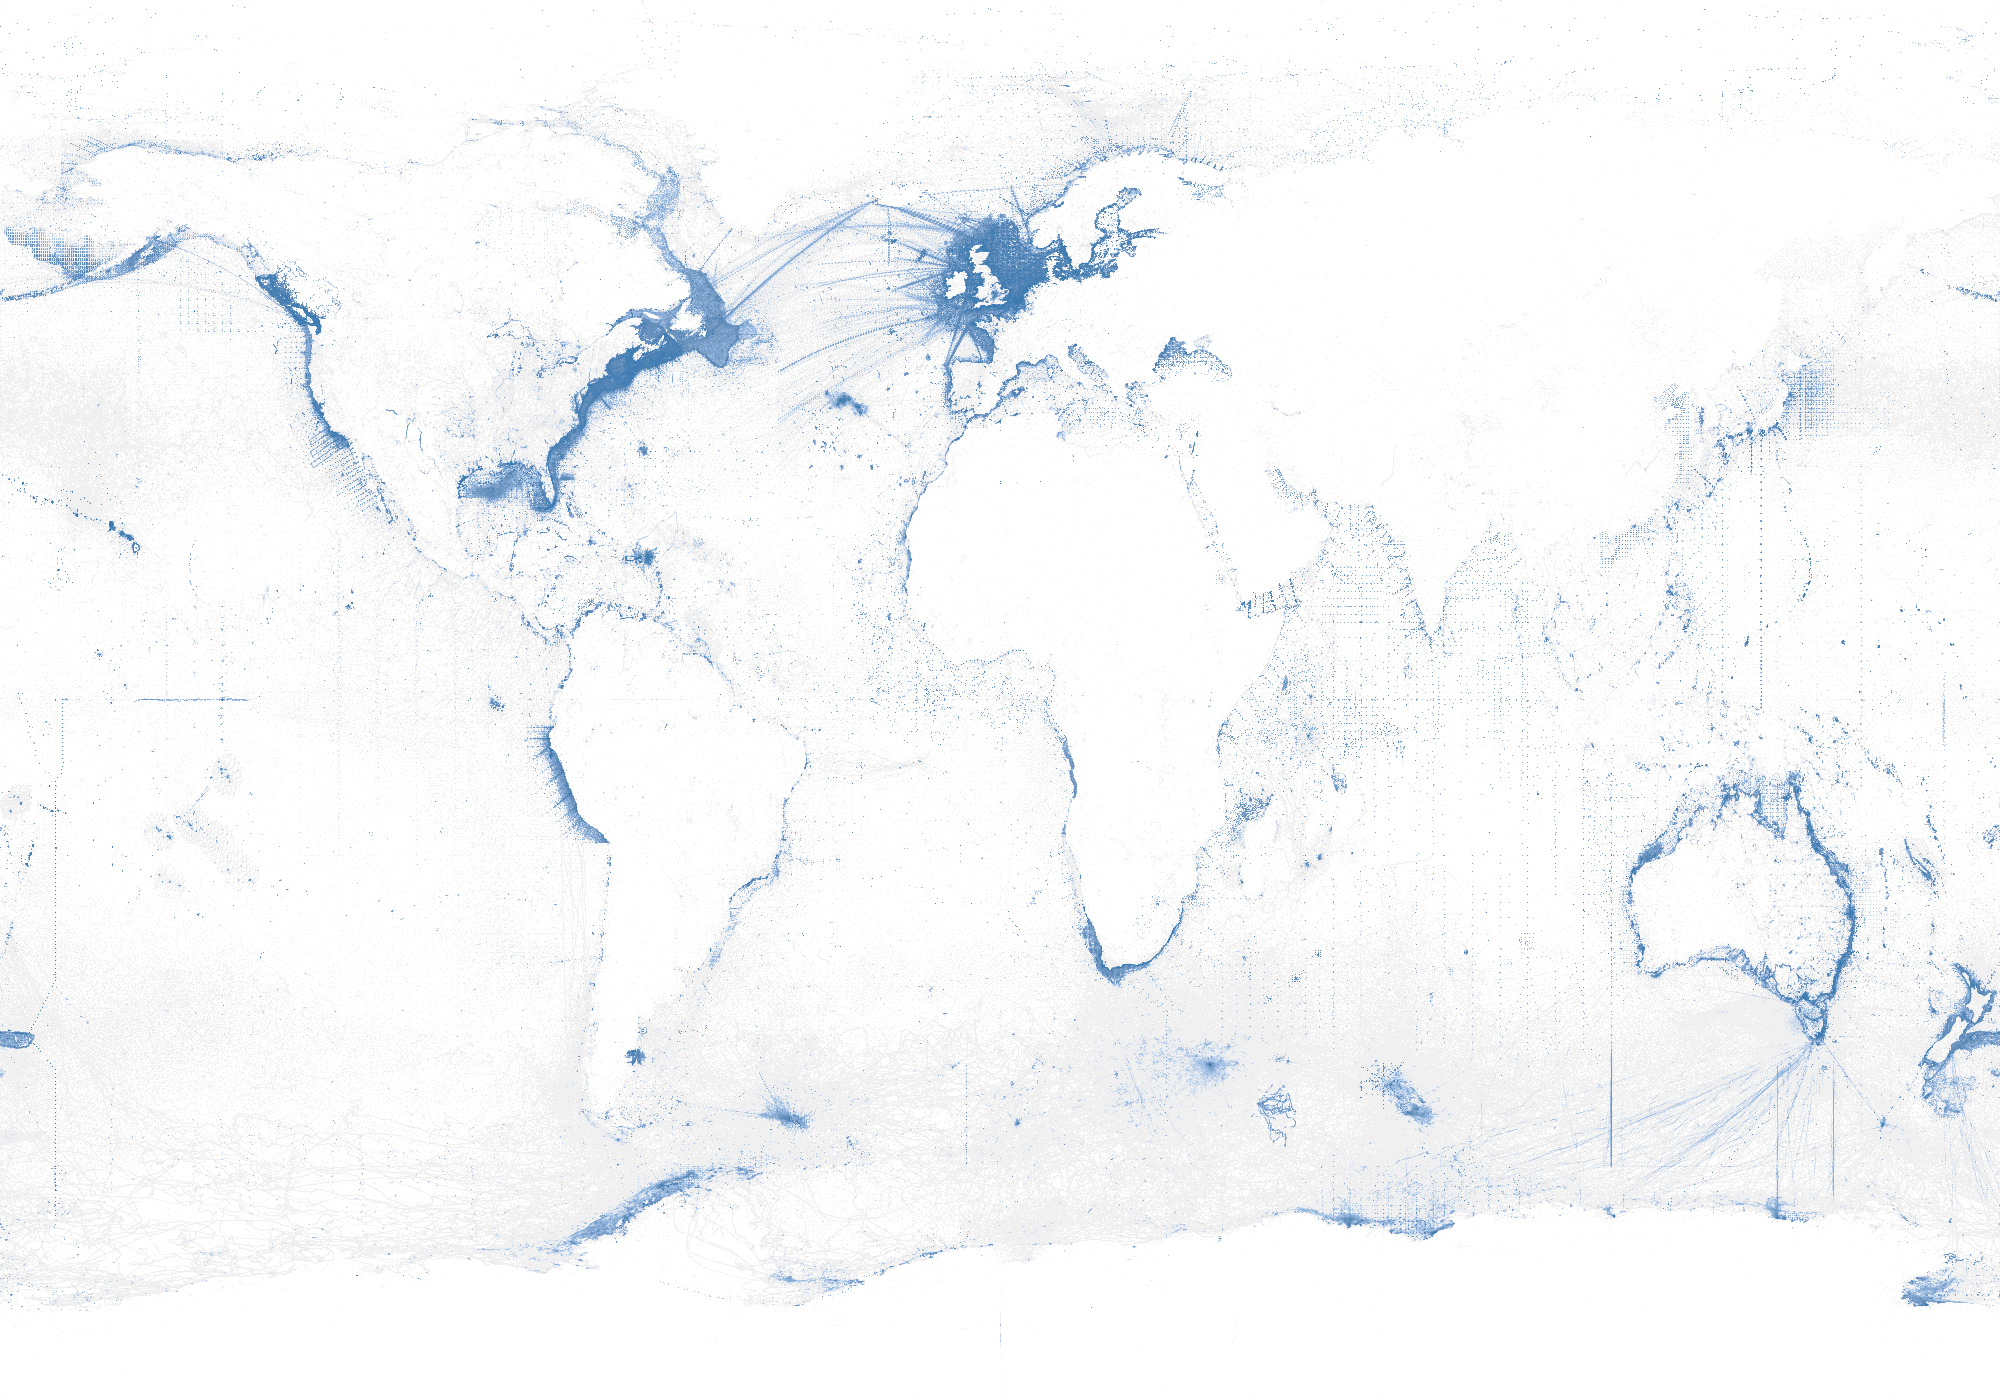

In [ ]:
import datashader as ds
import colorcet

cvs = ds.Canvas(plot_width=2000, plot_height=1400)
agg = cvs.points(combined, 'decimalLongitude', 'decimalLatitude')
img = ds.tf.set_background(
            ds.tf.shade(agg,
                cmap=colorcet.blues,
                how='eq_hist',
                rescale_discrete_levels=True,
                ),
            "white")

img

Create latitude and longitude histograms of the count of occurrence records.

array([<AxesSubplot: title={'center': 'decimalLongitude'}>], dtype=object)

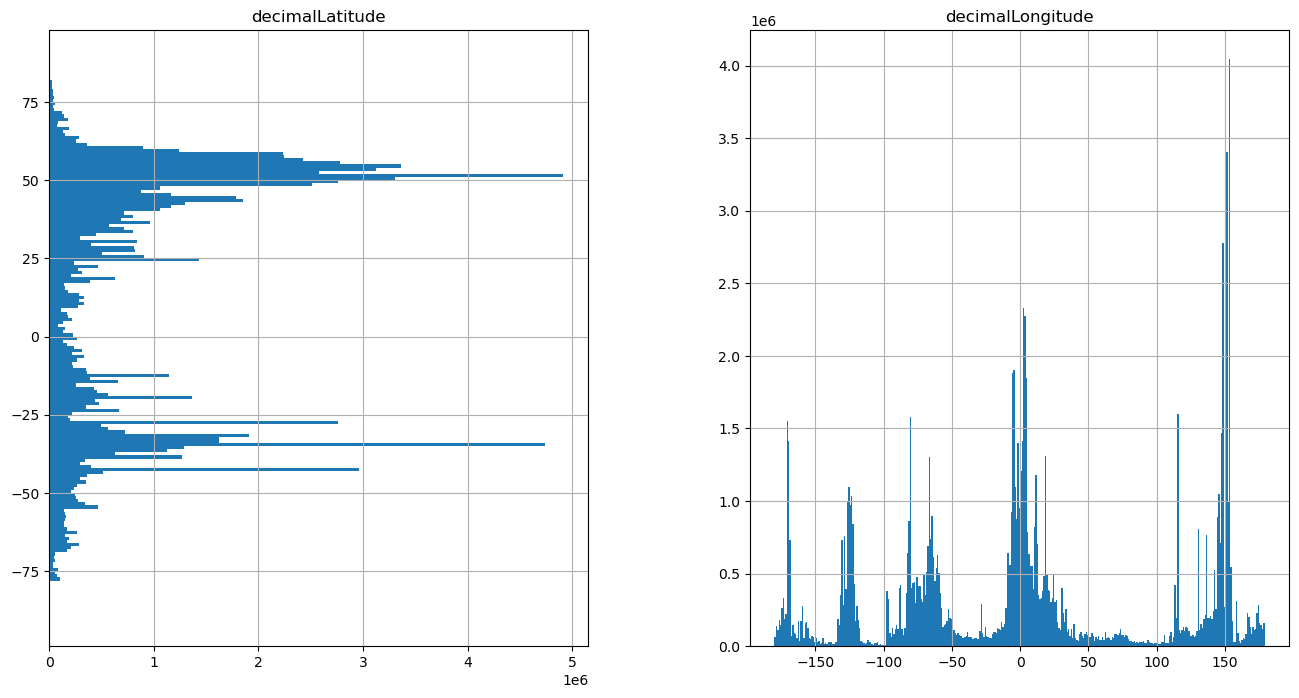

In [ ]:
bins_lat = [i for i in range(-90, 90, 1)]
bins_lon = [i for i in range(-180, 180, 1)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

combined.hist(
    column="decimalLatitude", bins=bins_lat, orientation="horizontal", ax=ax[0]
)

combined.hist(
    column="decimalLongitude", bins=bins_lon, orientation="vertical", ax=ax[1]
)

Add latitude and longitude histograms to datashader figure.

TypeError: dsshow() missing 1 required positional argument: 'glyph'

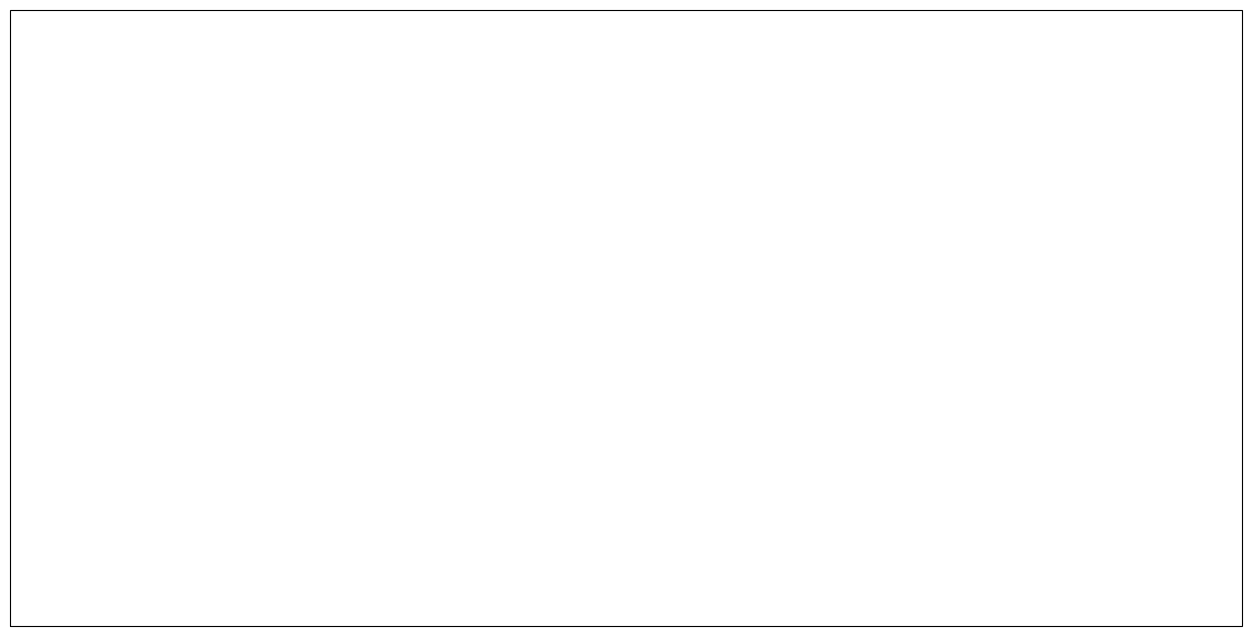

In [ ]:
import geoplot
import geoplot.crs as gcrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datashader.mpl_ext import dsshow, alpha_colormap

projection = gcrs.PlateCarree(central_longitude=-105)

fig, ax = plt.subplots(
    figsize=(16, 8), facecolor="white", subplot_kw={"projection": projection}
)


cvs = ds.Canvas(plot_width=2000, plot_height=1400)
agg = cvs.points(combined, 'decimalLongitude', 'decimalLatitude')
img = ds.tf.set_background(
            ds.tf.shade(agg,
                cmap=colorcet.blues,
                how='eq_hist',
                rescale_discrete_levels=True,
                ),
            "white")

dsshow(img,ax=ax)

#ax.add_image(img)


# Add histogram for distribution
ax2 = fig.add_axes([0.95, 0.090, 0.05, 0.8])

bins_lat = [i for i in range(20, 77, 1)]

combined.hist(
    column="decimalLatitude", bins=bins_lat, orientation="horizontal", ax=ax2, log=True
)

ax3 = fig.add_axes([0.09, 1, 0.825, 0.08])

bins_lon = [i for i in range(-179, -61, 1)]

combined.hist(
    column="decimalLongitude", bins=bins_lon, orientation="vertical", ax=ax3, log=True
)

# Let's make some histograms of occurrence record distributions across latitude and longitude

First, we need to create the bins by which we will calculate the number of occurrences. For this example we will use 1 degree bins. To do this, we will use geopandas and shapely.

First off, let's get the dataframe into something geopandas can work with.

**CAUTION** This takes a very long time to run.

In [ ]:
gdf_high_res = geopandas.GeoDataFrame(
    combined[["decimalLatitude", "decimalLongitude"]],
    geometry=geopandas.points_from_xy(
        combined.decimalLongitude, combined.decimalLatitude
    ),
    crs="epsg:4326",
)

# Create a grid of observations
1 degree x 1 degree

This creates a 1 degree by 1 degree grid, then counts the number of points from our source data that fall within each grid. Providing a heatmap of the number of occurrence records per 1 degree cell.

/home/filipe/micromamba/envs/IOOS/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/home/filipe/micromamba/envs/IOOS/lib/python3.11/site-packages/shapely/measurement.py:45: RuntimeWarning: invalid value encountered in area
  return lib.area(geometry, **kwargs)


<Axes: >

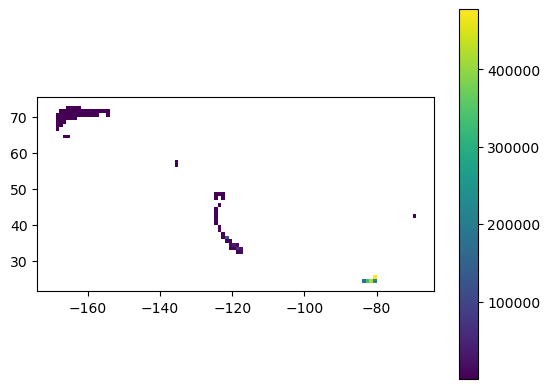

In [ ]:
import numpy as np
import shapely

# total area for the grid
xmin, ymin, xmax, ymax = [-180.0, -90.0, 180.0, 90]

# how many cells across and down
n_cells = 360

# calculate the size of the cells
cell_size = (xmax - xmin) / n_cells

# create an evenly distributed GeoDataFrame for the grid described above
grid_cells = []
for x0 in np.arange(xmin, xmax + cell_size, cell_size):
    for y0 in np.arange(ymin, ymax + cell_size, cell_size):
        # bounds
        x1 = x0 - cell_size
        y1 = y0 + cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))

cell = geopandas.GeoDataFrame(grid_cells, columns=["geometry"], crs="EPSG:4326")

# spatial join the OBIS data with the one-degree cells for where OBIS data are within cells.
merged = geopandas.sjoin(gdf_high_res, cell, how="left", op="within")

# make a simple count variable that we can sum for each cell
merged["n_occur"] = 1

# Compute stats per grid cell -- aggregate occurences to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="count")

# put this into cell
cell.loc[dissolve.index, "n_occur"] = dissolve.n_occur.values

# calculate occurrence density in km^2 for each cell.
# cell["area (km2)"] = cell.to_crs(epsg=3763).area / (1000**2)

cell.plot(column="n_occur", legend=True)

Next, let's check out the distribution of the values for `n_occur` so we can make an appropriatly legible map of the distribution.

In [ ]:
cell.describe()

,n_occur,area (km2)
count,80.000000,6.449600e+04
mean,25000.212500,inf
std,84580.460311,NaN
min,10.000000,1.088584e+02
25%,156.500000,5.065842e+03
50%,594.000000,1.071955e+04
75%,2487.500000,1.742916e+04
max,477661.000000,inf


Since the distribution of `n_occur` covers a wide range, we will present the concentration and histogram figures as log normal distributions.

So, let's combine the latitude and longitude histograms with the map to recreate this figure https://bbest.github.io/obis-lat-time-fig/#map,_hist,_time-series_combined.

array([<Axes: title={'center': 'decimalLongitude'}>], dtype=object)

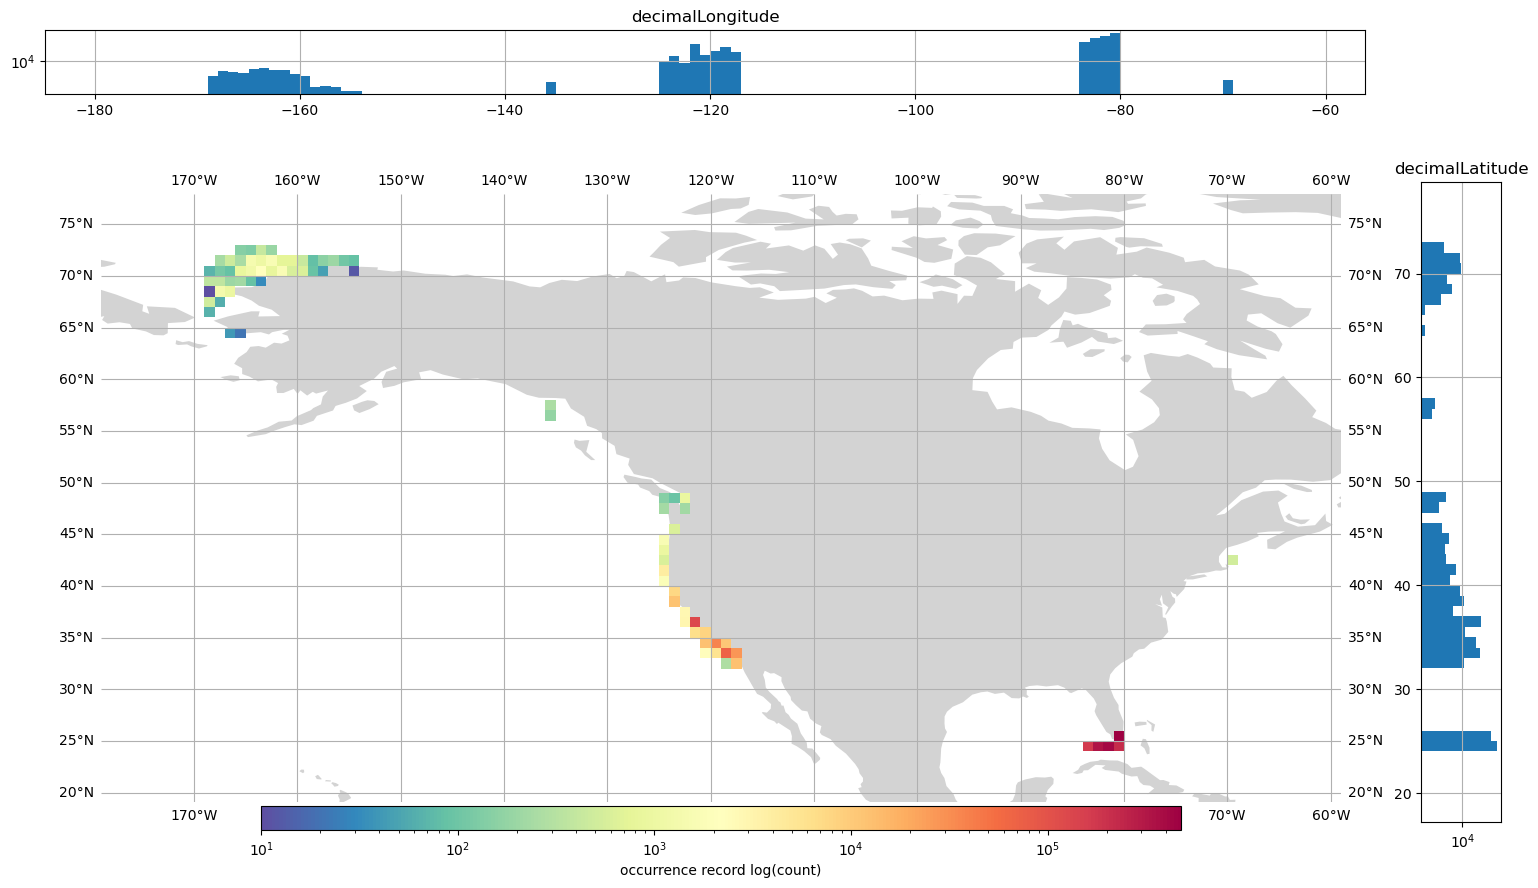

In [ ]:
import geoplot
import geoplot.crs as gcrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

norm = mpl.colors.LogNorm(vmin=cell["n_occur"].min(), vmax=cell["n_occur"].max())

projection = gcrs.PlateCarree(central_longitude=-105)

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
world = world.dissolve()

fig, ax = plt.subplots(
    figsize=(16, 8), facecolor="white", subplot_kw={"projection": projection}
)

geoplot.polyplot(
    world,
    facecolor="lightgray",
    edgecolor=None,
    projection=projection,
    ax=ax,
)


cax = fig.add_axes([0.225, 0.08, 0.575, 0.03])


cell = cell[~cell["n_occur"].isna()]

geoplot.choropleth(
    cell,
    hue="n_occur",
    edgecolor=None,
    projection=projection,
    ax=ax,
    cmap="Spectral_r",
    legend=True,
    legend_kwargs={
        "orientation": "horizontal",
        "cax": cax,
        "label": "occurrence record log(count)",
    },
    norm=norm,
)

gl = ax.gridlines(draw_labels=True)
gl.ylocator = mticker.FixedLocator(range(0, 90, 5))
gl.xlocator = mticker.FixedLocator(range(-170, -40, 10))


# Add histogram for distribution
ax2 = fig.add_axes([0.95, 0.090, 0.05, 0.8])

bins_lat = [i for i in range(20, 77, 1)]

gdf_high_res.hist(
    column="decimalLatitude", bins=bins_lat, orientation="horizontal", ax=ax2, log=True
)

ax3 = fig.add_axes([0.09, 1, 0.825, 0.08])

bins_lon = [i for i in range(-179, -61, 1)]

gdf_high_res.hist(
    column="decimalLongitude", bins=bins_lon, orientation="vertical", ax=ax3, log=True
)